### Theory 3:
##### What is  the correlation between ratings and sales?
* Are movies with higher ratings generating more   net profit than less rated ones? 


In [1]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress
import json
from config import api_key

url = "http://www.omdbapi.com/?t="
api_key = "&apikey=" + api_key

movies_path = "mcu_domestic_global_box_office.csv"
movies_df = pd.read_csv(movies_path)
movies_df.head()


,Release Date,Movie,Production Budget,Opening Weekend,Domestic Box Office,Worldwide Box Office
0,5/2/08,Iron Man,"$186,000,000","$102,118,668","$318,604,126","$585,171,547"
1,6/13/08,The Incredible Hulk,"$137,500,000","$55,414,050","$134,806,913","$265,573,859"
2,5/7/10,Iron Man 2,"$170,000,000","$128,122,480","$312,433,331","$621,156,389"
3,5/6/11,Thor,"$150,000,000","$65,723,338","$181,030,624","$449,326,618"
4,7/22/11,Captain America: The First Avenger,"$140,000,000","$65,058,524","$176,654,505","$370,569,776"


In [2]:
imdb_rating = []
rotten_tomatoes_rating = []
metacritic_rating = []
imdb_rating_float = 0.0


for index in range(len(movies_df)):
    movie_name = movies_df.iloc[index]['Movie']
    response = requests.get(url + movie_name + api_key)
    data = response.json()
    imdb_rating_float = data['imdbRating'] 
    imdb_rating.append(float(imdb_rating_float))
    rotten_tomatoes_rating.append(data['Ratings'][1]['Value'])
    metacritic_rating.append(data['Ratings'][2]['Value'])


In [3]:
movies_df['Rotten_Tomatoes_Rating_%'] = rotten_tomatoes_rating
movies_df['IMDB_Rating'] = imdb_rating
movies_df['Metacritic_Rating'] = metacritic_rating
movies_df.head()

,Release Date,Movie,Production Budget,Opening Weekend,Domestic Box Office,Worldwide Box Office,Rotten_Tomatoes_Rating_%,IMDB_Rating,Metacritic_Rating
0,5/2/08,Iron Man,"$186,000,000","$102,118,668","$318,604,126","$585,171,547",94%,7.9,79/100
1,6/13/08,The Incredible Hulk,"$137,500,000","$55,414,050","$134,806,913","$265,573,859",67%,6.7,61/100
2,5/7/10,Iron Man 2,"$170,000,000","$128,122,480","$312,433,331","$621,156,389",72%,7.0,57/100
3,5/6/11,Thor,"$150,000,000","$65,723,338","$181,030,624","$449,326,618",77%,7.0,57/100
4,7/22/11,Captain America: The First Avenger,"$140,000,000","$65,058,524","$176,654,505","$370,569,776",80%,6.9,66/100


In [4]:

movies_df['Domestic Box Office']= movies_df['Domestic Box Office'].replace('[$,.]',"",regex=True).astype(float)
movies_df['Worldwide Box Office']= movies_df['Worldwide Box Office'].replace('[$,.]',"",regex=True).astype(float)
movies_df['Production Budget']= movies_df['Production Budget'].replace('[$,.]',"",regex=True).astype(float)
movies_df['Opening Weekend']= movies_df['Opening Weekend'].replace('[$,.]',"",regex=True).astype(float)
movies_df['Net Profit'] = movies_df['Domestic Box Office'] - movies_df['Production Budget']

movies_df['Release Date'] = pd.to_datetime(movies_df['Release Date'])

movies_df['Rotten_Tomatoes_Rating_%'] = movies_df['Rotten_Tomatoes_Rating_%'].str.replace('%','').astype(float)
movies_df['Metacritic_Rating'] = movies_df['Metacritic_Rating'].str.replace('/100','').astype(float)

movies_df.head()


,Release Date,Movie,Production Budget,Opening Weekend,Domestic Box Office,Worldwide Box Office,Rotten_Tomatoes_Rating_%,IMDB_Rating,Metacritic_Rating,Net Profit
0,2008-05-02,Iron Man,186000000.0,102118668.0,318604126.0,585171547.0,94.0,7.9,79.0,132604126.0
1,2008-06-13,The Incredible Hulk,137500000.0,55414050.0,134806913.0,265573859.0,67.0,6.7,61.0,-2693087.0
2,2010-05-07,Iron Man 2,170000000.0,128122480.0,312433331.0,621156389.0,72.0,7.0,57.0,142433331.0
3,2011-05-06,Thor,150000000.0,65723338.0,181030624.0,449326618.0,77.0,7.0,57.0,31030624.0
4,2011-07-22,Captain America: The First Avenger,140000000.0,65058524.0,176654505.0,370569776.0,80.0,6.9,66.0,36654505.0


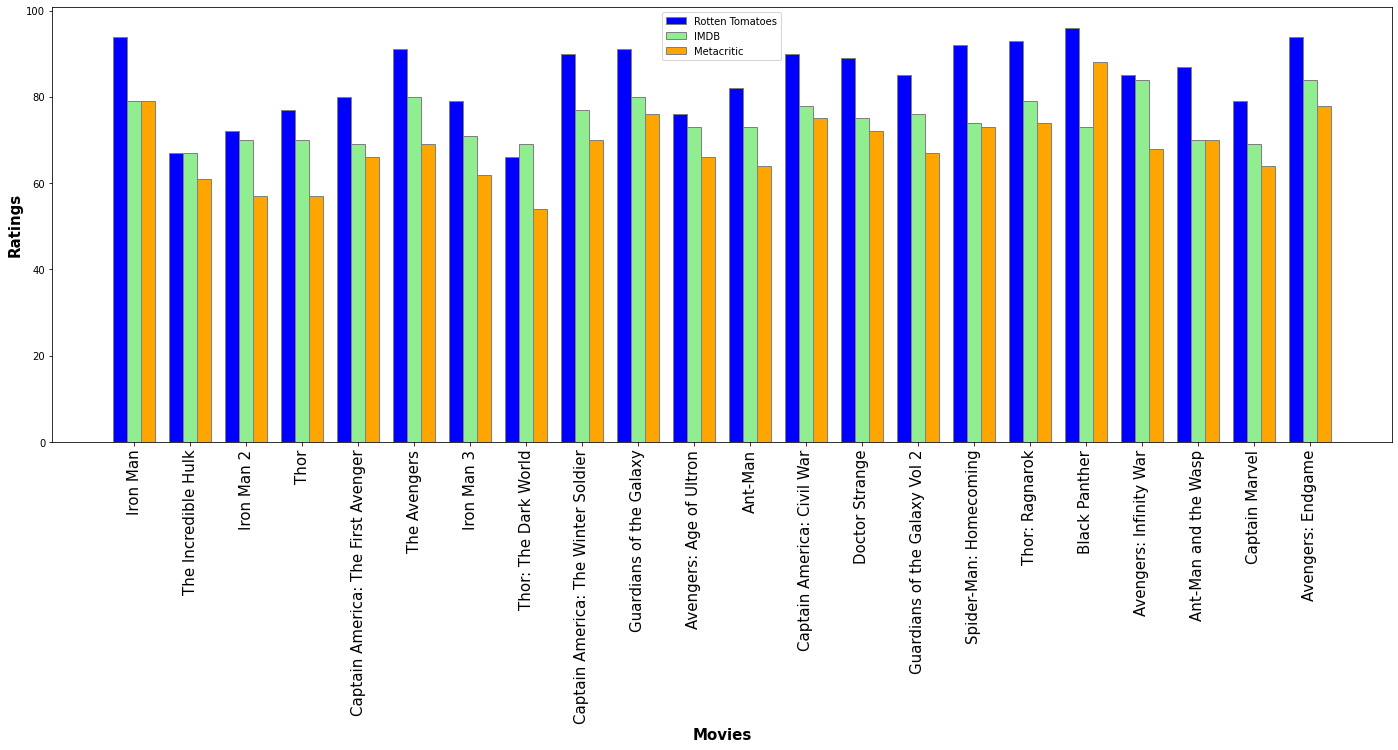

In [5]:
RT = movies_df['Rotten_Tomatoes_Rating_%'] 
IMDB = movies_df['IMDB_Rating'] * 10
Metac = movies_df['Metacritic_Rating']
 
barWidth = 0.25
fig = plt.subplots(figsize =(24, 8))
x_pos = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,32,34,36,38,40,42,44]
 
# Set position of bar on X axis
br1 = np.arange(len(RT))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

 
# Make the plot
plt.bar(br1, RT, color ='blue', width = barWidth,
        edgecolor ='grey', label ='Rotten Tomatoes')
plt.bar(br2, IMDB, color ='lightgreen', width = barWidth,
        edgecolor ='grey', label ='IMDB')
plt.bar(br3, Metac, color ='orange', width = barWidth,
        edgecolor ='grey', label ='Metacritic')
 
# Adding Xticks
plt.xlabel('Movies', fontweight ='bold', fontsize = 15)
plt.ylabel('Ratings', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(RT))],movies_df['Movie'])

plt.xticks(rotation="vertical",fontsize = 15)
plt.savefig('Fig00.png')
plt.legend()
plt.show()

The r-value is: 0.52


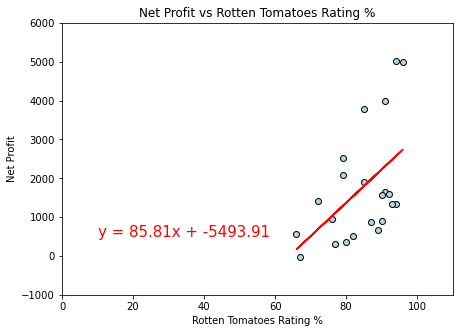

In [6]:
y_axis = movies_df['Net Profit']/100000

x_axis = movies_df['Rotten_Tomatoes_Rating_%'] 
fig = plt.subplots(figsize =(7, 5))
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(10,500),fontsize=15,color="red")

plt.scatter(x_axis, y_axis, marker="o", facecolors="lightblue", edgecolors="black", alpha=1)
plt.xlim(0, 110)
plt.ylim(-1000, 6000)
plt.ylabel("Net Profit")
plt.xlabel("Rotten Tomatoes Rating %")
plt.title(f"Net Profit vs Rotten Tomatoes Rating %" )
print(f"The r-value is: {round(rvalue,2)}")
plt.savefig('Fig01.png')
plt.show()


The r-value is: 0.57


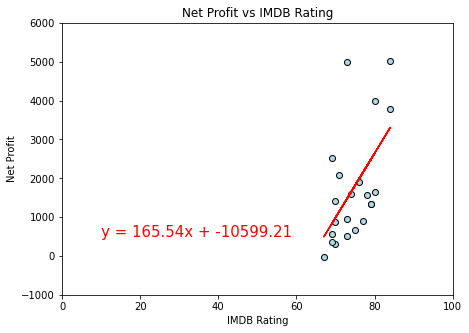

In [7]:
y_axis = movies_df['Net Profit']/100000
x_axis = movies_df['IMDB_Rating'] * 10
fig = plt.subplots(figsize =(7, 5))
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(10,500),fontsize=15,color="red")


plt.scatter(x_axis, y_axis, marker="o", facecolors="lightblue", edgecolors="black", alpha=1)
plt.xlim(0, 100)
plt.ylim(-1000, 6000)
plt.ylabel("Net Profit")
plt.xlabel("IMDB Rating")
plt.title(f"Net Profit vs IMDB Rating" )
print(f"The r-value is: {round(rvalue,2)}")

plt.savefig('Fig02.png')
plt.show()

The r-value is: 0.54


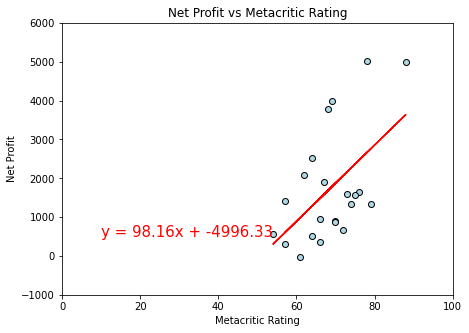

In [8]:
y_axis = movies_df['Net Profit']/100000
x_axis = movies_df['Metacritic_Rating'] 
fig = plt.subplots(figsize =(7, 5))
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(10,500),fontsize=15,color="red")


plt.scatter(x_axis, y_axis, marker="o", facecolors="lightblue", edgecolors="black",alpha=1)
plt.xlim(0, 100)
plt.ylim(-1000, 6000)
plt.ylabel("Net Profit")
plt.xlabel("Metacritic Rating")
plt.title(f"Net Profit vs Metacritic Rating" )
print(f"The r-value is: {round(rvalue,2)}")
plt.savefig('Fig03.png')
plt.show()